# LongLLaMA: Focused Transformer Training for Context Scaling
**LongLLaMA is a large language model capable of handling long contexts of 256k tokens or even more**.

It is built upon the foundation of [OpenLLaMA](https://github.com/openlm-research/open_llama) and fine-tuned using the Focused Transformer (FoT) method.  We release a smaller 3B variant of the LongLLaMA model on a permissive license (Apache 2.0) and inference code supporting longer contexts on [Hugging Face](https://huggingface.co/syzymon/long_llama_3b). Our model weights can serve as the drop-in replacement of LLaMA in existing implementations (for short context up to 2048 tokens).

For more, see [FoT paper](https://arxiv.org/abs/2307.03170) and [GitHub repository](https://github.com/CStanKonrad/long_llama).

## Usage

### Requirements

In [ ]:
!pip install --upgrade pip
!pip install transformers==4.30  sentencepiece accelerate -q

### Loading model

In [ ]:
import torch
from transformers import LlamaTokenizer, AutoModelForCausalLM

In [ ]:
MODEL_PATH = 'syzymon/long_llama_3b'
TOKENIZER_PATH = 'syzymon/long_llama_3b'
# to fit into colab GPU we will use reduced precision
TORCH_DTYPE = torch.bfloat16

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [ ]:
tokenizer = LlamaTokenizer.from_pretrained(TOKENIZER_PATH)

model = AutoModelForCausalLM.from_pretrained(MODEL_PATH,
                                            torch_dtype=TORCH_DTYPE,
                                            device_map=device,
                                            trust_remote_code=True,
                                            # mem_attention_grouping is used
                                            # to trade speed for memory usage
                                            # for details see the section Additional configuration
                                            mem_attention_grouping=(1, 2048))
model.eval()

### Input handling and generation
LongLLaMA uses the Hugging Face interface, the long input given to the model will be
split into context windows and loaded into the memory cache.

In [ ]:
from transformers import TextStreamer
streamer = TextStreamer(tokenizer)

prompt = "My name is Julien and I like to"
input_ids = tokenizer(prompt, return_tensors="pt").input_ids
input_ids = input_ids.to(device)

torch.manual_seed(60)
generation_output = model.generate(
    input_ids=input_ids,
    max_new_tokens=256,
    num_beams=1,
    last_context_length=1792,
    do_sample=True,
    temperature=1.0,
    streamer=streamer,
)

During the model call, one can provide the parameter `last_context_length` (default $1024$), which specifies the number of tokens left in the last context window. Tuning this parameter can improve generation as the first layers do not have access to memory. See details in section: How LongLLaMA handles long inputs.

### Additional configuration
LongLLaMa has several other parameters:
* `mem_layers` specifies layers endowed with memory (should be either an empty list or a list of all memory layers specified in the description of the checkpoint).
* `mem_dtype` allows changing the type of memory cache
* `mem_attention_grouping` can trade off speed for reduced memory usage.
  When equal to `(4, 2048)`, the memory layers will process at most $4*2048$ queries at once ($4$ heads and $2048$ queries for each head).

```python3
model = AutoModelForCausalLM.from_pretrained(
    MODEL_PATH, torch_dtype=torch.float32,
    mem_layers=[],
    mem_dtype='bfloat16',
    trust_remote_code=True,
    mem_attention_grouping=(4, 2048),
)
```

## Passkey retrieval
The code below allows us to test the model on the passkey retrieval task from [Landmark Attention: Random-Access Infinite Context Length for Transformers](https://arxiv.org/abs/2305.16300), showcasing the ability to handle long context lengths. Below see the prompt format used in this task (copied from the paper).

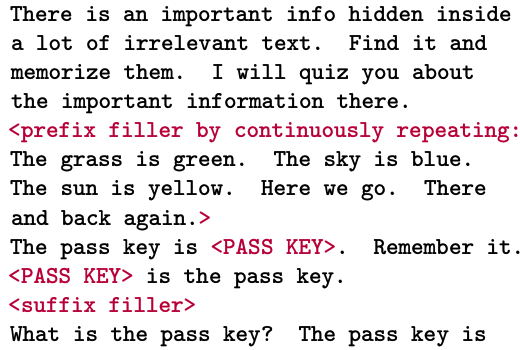

In [ ]:
# This is a modification of the original code
# https://github.com/epfml/landmark-attention/blob/111ee30e693ccc23a12b57c1d41f8ae2cc5b4867/llama/run_test.py#L96
# The original code license:
# Copyright 2023 Amirkeivan Mohtashami, Martin Jaggi
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

from numpy import random


def generate_prompt_landmark(n_garbage, seed):
    """Generates a text file and inserts an passkey at a random position."""
    rnd_state = random.get_state()
    random.seed(seed)
    n_garbage_prefix = random.randint(0, n_garbage)
    n_garbage_suffix = n_garbage - n_garbage_prefix

    task_description = "There is an important info hidden inside a lot of irrelevant text. Find it and memorize them. I will quiz you about the important information there."
    garbage = "The grass is green. The sky is blue. The sun is yellow. Here we go. There and back again."
    garbage_inf = " ".join([garbage] * 5000)
    assert len(garbage_inf) >= n_garbage
    garbage_prefix = garbage_inf[:n_garbage_prefix]
    garbage_suffix = garbage_inf[:n_garbage_suffix]
    pass_key = random.randint(1, 50000)
    information_line = f"The pass key is {pass_key}. Remember it. {pass_key} is the pass key."
    final_question = "What is the pass key? The pass key is"
    lines = [
        task_description,
        garbage_prefix,
        information_line,
        garbage_suffix,
        final_question,
    ]
    random.set_state(rnd_state)
    return "\n".join(lines), str(pass_key)

In [ ]:
def passkey_retrieval_test(n_garbage=60000, seed=555):

  #n_garbage=60000 results in ~16k tokens

  prompt, answer = generate_prompt_landmark(n_garbage, seed)
  input_ids = tokenizer(prompt, return_tensors="pt").input_ids
  input_ids = input_ids.to(device)
  print(f"Prompt has {input_ids.shape[-1]} tokens")

  answer_ids = tokenizer(answer, return_tensors="pt").input_ids[:, 1:] # drop BOS
  generation_output = model.generate(
      input_ids=input_ids, max_new_tokens=answer_ids.shape[-1], num_beams=1, last_context_length=1024
  )

  model_answer = generation_output[0, -answer_ids.shape[-1]:].cpu()

  is_correct = (model_answer == answer_ids[0]).all().item()
  print(f"The correct answer is {tokenizer.decode(answer_ids[0].cpu())}")
  print(f"The model answer is {tokenizer.decode(model_answer.cpu())}, is_correct : {is_correct}")
  return is_correct


passkey_retrieval_test()

In [ ]:
num_tests = 10
passed_tests = 0
for i in range(num_tests):
  passed_tests += passkey_retrieval_test(n_garbage=60000, seed=i)

print(f"Accuracy is {passed_tests/num_tests}")

### How LongLLaMA handles long inputs
Inputs over $2048$ tokens are automatically split into windows $w_1, \ldots, w_m$. The first $m-2$ windows contain $2048$ tokens each, $w_{m-1}$ has no more than $2048$ tokens, and $w_m$ contains the number of tokens specified by `last_context_length`. The model processes the windows one by one extending the memory cache after each. If `use_cache` is `True`, the last window will not be loaded to the memory cache but to the local (generation) cache.

The memory cache stores $(key, value)$ pairs for each head of the specified memory layers `mem_layers`. In addition to this, it stores attention masks.

If `use_cache=True` (which is the case in generation), LongLLaMA will use two caches: the memory cache for the specified layers and the local (generation) cache for all layers. When the local cache exceeds $2048$ elements, its content is moved to the memory cache for the memory layers.

For simplicity, context extension is realized with a memory cache and full attention in this repo. Replacing this simple mechanism with a KNN search over an external database is possible with systems like [Faiss](https://github.com/facebookresearch/faiss). This potentially would enable further context length scaling. We leave this as a future work.